In [1]:
# libraries
import os
import datetime as dt
from collections import Counter
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [2]:
# DIRECTORY PATH
RAW_DATA_DIRECTORY = 'raw_data'
DATA_DIRECTORY = 'data'

# FLOW DATA
RAW_FLOW_CSV = 'd12_text_station_5min_2019_10_08.txt.gz'
RAW_FLOW_PARQUET = 'd12_raw_flow_191008.parquet'
RAW_FLOW_COLS_TO_IMPORT = list(range(0, 12))
RAW_FLOW_COLS_NAMES = ['timestamp', 'station', 'district', 'freeway_num', 'direction', \
     'lane_type', 'station_length', 'samples', 'pct_observed', 'total_flow', \
     'avg_occupancy', 'avg_speed']

# STATION DATA
RAW_STATION_CSV = 'd12_text_meta_2019_11_05.txt'
RAW_STATION_PARQUET = 'd12_raw_station.parquet'
RAW_SCOLS_TO_IMPORT = ['ID', 'Fwy', 'Dir', 'District', 'County', 'Abs_PM', 'Latitude', 'Longitude']

# PM DATA
RAW_PM_CSV = 'SHN_Postmiles_Tenth.csv'
RAW_PM_PARQUET = 'raw_pm.parquet'
RAW_PMCOLS_TO_IMPORT = [0, 1, 3, 8, 10, 12, 16]

# Load datasets

- `flowdf`
- `sdf`
- `pmdf`

In [17]:
def load_data():
    # file path
    csv_flow_file = os.path.join(RAW_DATA_DIRECTORY, RAW_FLOW_CSV)
    parquet_flow_file = os.path.join(DATA_DIRECTORY, RAW_FLOW_PARQUET)
    csv_station_file = os.path.join(RAW_DATA_DIRECTORY, RAW_STATION_CSV)
    parquet_station_file = os.path.join(DATA_DIRECTORY, RAW_STATION_PARQUET)
    csv_pm_file = os.path.join(RAW_DATA_DIRECTORY, RAW_PM_CSV)
    parquet_pm_file = os.path.join(DATA_DIRECTORY, RAW_PM_PARQUET)

    # flow data
    if os.path.exists(parquet_flow_file):
        print('Parquet Flow Data Loaded')
        raw_flow_df = pd.read_parquet(parquet_flow_file)
    else:
        print('CSV Flow Data Loaded')
        raw_flow_df = pd.read_csv(csv_flow_file, compression='gzip', delimiter=',', header=None, usecols=RAW_FLOW_COLS_TO_IMPORT)
        raw_flow_df.columns = RAW_FLOW_COLS_NAMES

    # station_pm data
    if os.path.exists(parquet_station_file):
        print('Parquet Station Data Loaded')
        raw_station_df = pd.read_parquet(parquet_station_file)
    else:
        print('CSV Station Data Loaded')
        raw_station_df = pd.read_csv(csv_station_file, delimiter='\t', usecols=RAW_SCOLS_TO_IMPORT)
    sdf_col_names = ['station', 'freeway_num', 'direction', 'district', 'county', 'abs_pm', 'latitude', 'longitude']
    raw_station_df.columns = sdf_col_names

    # pm_df
    if os.path.exists(parquet_pm_file):
        print('Parquet PM Data Loaded')
        raw_pm_df = pd.read_parquet(parquet_pm_file)
    else:
        print('CSV PM Data Loaded')
        raw_pm_df = pd.read_csv(csv_pm_file, usecols=RAW_PMCOLS_TO_IMPORT)

    # pm_df lat and long conversion
    # from pyproj import Proj, transform
    #
    # in_proj = Proj(init='epsg:3857')  # Input coordinate system (Web Mercator)
    # out_proj = Proj(init='epsg:4326')  # Output coordinate system (WGS84)
    #
    # x = pmdf['X']  # Original x-coordinate
    # y = pmdf['Y']  # Original y-coordinate
    #
    # pmdf['longitude'], pmdf['latitude'] = transform(in_proj, out_proj, x, y)
    #
    return raw_flow_df, raw_station_df, raw_pm_df

In [18]:
# load raw data
raw_flowdf, sdf, pmdf = load_data()

Parquet Flow Data Loaded
Parquet Station Data Loaded
Parquet PM Data Loaded


In [19]:
raw_flowdf.head()

,timestamp,station,district,freeway_num,direction,lane_type,station_length,samples,pct_observed,total_flow,avg_occupancy,avg_speed
2,2019-10-08 00:00:00-07:00,1201054,12,133,S,ML,1.285,30,100,8.0,0.0038,68.8
5,2019-10-08 00:00:00-07:00,1201066,12,133,N,ML,0.670,20,100,11.0,0.0044,65.7
7,2019-10-08 00:00:00-07:00,1201076,12,133,N,ML,0.185,0,0,44.0,0.0292,60.9
9,2019-10-08 00:00:00-07:00,1201085,12,405,S,HV,0.180,10,100,3.0,0.0022,65.0
10,2019-10-08 00:00:00-07:00,1201087,12,405,S,ML,0.180,50,100,67.0,0.0066,72.1


In [6]:
sdf.head()

,station,freeway_num,direction,district,county,abs_pm,latitude,longitude
0,1201044,133,S,12,59,8.991,33.661840,-117.755300
1,1201052,133,S,12,59,8.991,33.661840,-117.755300
2,1201054,133,S,12,59,8.991,33.661840,-117.755300
3,1201058,133,N,12,59,8.857,33.659542,-117.756294
4,1201064,133,N,12,59,8.723,33.657392,-117.757636


In [7]:
pmdf.head()

,X,Y,Route,District,PM,PMc,AlignCode,longitude,latitude
0,-1.371930e+07,4.652531e+06,1,4,32.647999,32.648,Left,-123.242583,38.515671
1,-1.371923e+07,4.652599e+06,1,4,32.599998,32.6,Left,-123.241985,38.516151
2,-1.371919e+07,4.652779e+06,1,4,32.500000,32.5,Left,-123.241586,38.517415
3,-1.371908e+07,4.652457e+06,1,4,32.299999,32.3,Left,-123.240602,38.515148
4,-1.371871e+07,4.652367e+06,1,4,32.099998,32.1,Left,-123.237282,38.514516


# Check the type of each column

In [20]:
raw_flowdf.dtypes

timestamp         datetime64[ns, America/Los_Angeles]
station                                         int64
district                                        int64
freeway_num                                     int64
direction                                      object
lane_type                                      object
station_length                                float64
samples                                         int64
pct_observed                                    int64
total_flow                                    float64
avg_occupancy                                 float64
avg_speed                                     float64
dtype: object

In [9]:
sdf.dtypes

station          int64
freeway_num      int64
direction       object
district         int64
county           int64
abs_pm         float64
latitude       float64
longitude      float64
dtype: object

In [11]:
pmdf.dtypes

X            float64
Y            float64
Route          int64
District       int64
PM           float64
PMc           object
AlignCode     object
longitude    float64
latitude     float64
dtype: object

# Modify Raw Flow df

In [23]:
def tweak_raw_flow(raw_flowdf):
    """
    :param df:
    :return:
    This function processes a DataFrame 'df' by performing several operations:
    - Converts the 'timestamp' column to datetime with a specific timezone.
    - Checks the 'timestamp' column for specific unique hours and minutes.
    - Filters the 'lane_type' column to keep only 'ML' and 'HV'.
    It returns the processed DataFrame.
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    df = raw_flowdf.copy()

    # timestamp
    # convert to datetime format with timezone
    if not df['timestamp'].dtypes == 'datetime64[ns, America/Los_Angeles]':
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
        df['timestamp'] = df['timestamp'].dt.tz_localize('America/Los_Angeles')

    # check timestamp hour and minutes
    unique_timestamps = df['timestamp'].unique()
    unique_hours = unique_timestamps.hour
    unique_minutes = unique_timestamps.minute
    assert (len(unique_timestamps) == 288) & (set(unique_hours) == set(range(0, 24))) \
            & (set(unique_minutes) == set(range(0, 60, 5))), 'please check timestamp column'

    hour_counts = Counter(unique_hours)
    assert all(hour_counts[hour] == 12 for hour in range(24)), 'hour is wrong, check timestamp column'

    minute_counts = Counter(unique_minutes)
    assert all(minute_counts[minute] == 24 for minute in range(0, 60, 5)), 'minute is wrong, check timestamp column'

    # keep only ML and HV for lane_type
    df = df[df['lane_type'].isin(['ML', 'HV'])]

    return df

In [24]:
flowdf = tweak_raw_flow(raw_flowdf)

## Select Desired Route, Direction, and Lane Type

- Sort by `timestamp` and `station`

### Route 405-N-ML as Test Case

- Check shape
- Check if each station is unique


In [30]:
def select_route(flowdf, freeway_num, direction, lane_type):

    # use assert to check the required columns
    required_columns = {'freeway_num', 'direction', 'lane_type'}
    assert required_columns.issubset(flowdf.columns), f"{flowdf} is missing some required columns."
    # Make a copy of the input DataFrame to avoid modifying the original
    df = flowdf.copy()

    # filter the df based on route number, direction, and lane type
    df = df[(df['freeway_num']==freeway_num) & (df['direction']==direction) & (df['lane_type']==lane_type)]

    # sort by timestamp and station, then reset index
    df = df.sort_values(['timestamp', 'station']).reset_index(drop=True)

    assert df.shape[1] == 12, 'The columns of route df is wrong'
    route_required_columns = ['timestamp', 'station', 'district', 'freeway_num', 'direction',
       'lane_type', 'station_length', 'samples', 'pct_observed', 'total_flow',
       'avg_occupancy', 'avg_speed']
    assert set(route_required_columns).issubset(df.columns), 'Some columns are not included in the df, check raw data'
    return df

In [38]:
I_405N_ML = select_route(flowdf, 405, 'N', 'ML')
I_405N_ML.shape

(16704, 12)

In [39]:
I_405N_ML.columns

Index(['timestamp', 'station', 'district', 'freeway_num', 'direction',
       'lane_type', 'station_length', 'samples', 'pct_observed', 'total_flow',
       'avg_occupancy', 'avg_speed'],
      dtype='object')

## Assign Null values to traffic flow

- Assigns NaN to the 'total_flow' column where the 'pct_observed' is less than 70

### Check NaN Values

- Pivot the raw df with index=station, columns=timestamp, values=total_flow
- Drop the row if the row includes more than 50% of NaN

### Naming

- {route_type}\_{route_num}{direction}\_{lane_type}

In [52]:
def assign_null_pivot(route_flow_df, observed_pct_thresh, pivot_value):
    """
    - Assigns NaN to the 'total_flow' column in the input DataFrame 'flow_df'
    for rows where the 'pct_observed' is less than the specified threshold.
    - Pivot the raw df with index=station, columns=timestamp, values=total_flow
    - Drop the row if the row includes more than 50% of NaN
    :param flow_df:
    :param observed_pct_thresh:
    :return:
    """
    # check the required columns of flow_df
    required_columns = {'pct_observed', 'total_flow', 'timestamp', 'station'}
    assert required_columns.issubset(route_flow_df.columns), f"{route_flow_df} is missing some required columns."
    assert route_flow_df['freeway_num'].nunique() == 1, "flow_df should have only one unique value in the 'station' column."
    assert route_flow_df['direction'].nunique() == 1, "flow_df should have only one unique value in the 'station' column."
    assert route_flow_df['lane_type'].nunique() == 1, "flow_df should have only one unique value in the 'station' column."

    df = route_flow_df.copy()

    # filter flow_df and assign NaN
    pct_observed_mask = df['pct_observed'] < observed_pct_thresh
    df.loc[pct_observed_mask, 'total_flow'] = np.nan

    # pivot df, each row is a station and each column is 5-min interval
    df_pivot = df.pivot(index='station', columns='timestamp', values=pivot_value).reset_index()

    # set threshold to drop rows: 50%
    drop_raw_threshold = len(df_pivot.columns) * 0.5
    # drop the raw if get the number of NaN values of a row across columns
    df_pivot_dropped = df_pivot.dropna(thresh=drop_raw_threshold)


    # rename all columns of pivoted df
    pivot_col_names = [f"{hour:02d}{minute:02d}" for hour in range(0, 24) for minute in range(0, 60, 5)]
    pivot_col_names.insert(0, 'station')
    df_pivot_dropped.columns = pivot_col_names

    # assert the number of columns
    assert df_pivot_dropped.shape[1] == 289, 'Wrong columns, check flowdf and route selection'
    return df_pivot_dropped

In [53]:
I_405N_ML_p = assign_null_pivot(I_405N_ML, 70, 'total_flow')
I_405N_ML_p.shape

(41, 289)

In [54]:
I_405S_ML = select_route(flowdf, 405, 'S', 'ML')
I_405S_ML_p = assign_null_pivot(I_405S_ML, 70, 'total_flow')

In [55]:
I_405N_ML_p.columns

Index(['station', '0000', '0005', '0010', '0015', '0020', '0025', '0030',
       '0035', '0040',
       ...
       '2310', '2315', '2320', '2325', '2330', '2335', '2340', '2345', '2350',
       '2355'],
      dtype='object', length=289)

## Merge with station_df

- Reset index
- Rename columns

In [56]:
sdf.columns

Index(['station', 'freeway_num', 'direction', 'district', 'county', 'abs_pm',
       'latitude', 'longitude'],
      dtype='object')

In [69]:
def merge_with_sdf(route_direct_type_p, sdf):

    # make copy of input dfs
    route_dir_type_p = route_direct_type_p.copy()
    sdf_copy = sdf.copy()

    # assert sdf's columns
    required_sdf_columns = {'station', 'abs_pm', 'latitude', 'longitude'}
    assert required_sdf_columns.issubset(sdf.columns), "missing columns in sdf"

    # merge two dfs
    route_dir_type_merged = pd.merge(route_dir_type_p, sdf_copy[['station', 'abs_pm', 'latitude', 'longitude']],
                                     on='station', how='left')
    route_dir_type_merged = route_dir_type_merged.sort_values('abs_pm').reset_index(drop=True)
    return route_dir_type_merged

In [70]:
# merge with station df
I_405N_ML_merged = merge_with_sdf(I_405N_ML_p, sdf)
I_405N_ML_merged.shape

(41, 292)

In [72]:
pmdf.columns

Index(['X', 'Y', 'Route', 'District', 'PM', 'PMc', 'AlignCode', 'longitude',
       'latitude'],
      dtype='object')

In [233]:
def extract_route_pm(raw_pmdf, district, route):
    """
    This function extract the route section and leave necessary for flow interpolation
    :param raw_pmdf:
    :param district:
    :param route:
    :return:
    """
    pmdf = raw_pmdf.copy()

    # filter by district, route, AlignCode='Left'
    route_pm_df = pmdf[(pmdf['District']==district) & (pmdf['Route']==route) & (pmdf['AlignCode']=='Left')]

    # delete unnecessary columns
    route_pm_df = route_pm_df.drop(columns=['X', 'Y', 'PMc', 'AlignCode'])

    # rename necessary columns
    route_pm_columns = ['freeway_num', 'district', 'abs_pm', 'longitude', 'latitude']
    route_pm_df.columns = route_pm_columns

    # round the abs_pm values and sort it
    route_pm_df['abs_pm'] = route_pm_df['abs_pm'].round(2)
    route_pm_df = route_pm_df.sort_values('abs_pm').reset_index(drop=True)

    return route_pm_df


In [235]:
I_405N_pm = extract_route_pm(pmdf, 12, 405)
I_405N_pm

,freeway_num,district,abs_pm,longitude,latitude
0,405,12,0.23,-117.735577,33.643991
1,405,12,0.30,-117.736518,33.644606
2,405,12,0.40,-117.738040,33.645283
3,405,12,0.50,-117.739672,33.645762
4,405,12,0.60,-117.741304,33.646240
...,...,...,...,...,...
236,405,12,23.80,-118.090590,33.780904
237,405,12,23.90,-118.090975,33.782308
238,405,12,24.00,-118.091464,33.783682
239,405,12,24.10,-118.092377,33.785060


In [236]:
len(I_405N_pm)

241

## Merge, fillna, Interpolation

Merge ready dfs:
- Flow: I_405N_ML_merged
- Postmile: I_405N_pm

In [266]:
def flow_interpolation(route_merged_df, route_pm_df):
    """
    This function combines route_merged_df and route_pm_df and calculate the flow at each pm
    It first creates bins (pm_range) based on route_pm_df and route_merged_df
    Then it calculates the mean of flow for each bin
    It fills out the nan values by backfill method across row (axis=0), then interpolate flow across columns (axis=1)
    For the last few nan rows beyond pm range from flow data, it forward fills nan
    :param route_merged_df:
    :param route_pm_df:
    :return: a
    """
    # make copies of input dfs
    route_df = route_merged_df.copy()
    pm_df = route_pm_df.copy()

    # create a list of bins that will be used for PM range later
    bins = [0] + pm_df['abs_pm'].tolist() + [np.inf]

    # append the bins to route_merged_df
    route_df['abs_pm_range'] = pd.cut(route_df['abs_pm'], bins=bins)

    # calculate mean flow
    route_mean_flow = route_df.iloc[:, 1:].groupby('abs_pm_range').mean().reset_index().iloc[:, 0:-2]

    # delete the last row (last_pm, np.inf]
    route_mean_flow = route_mean_flow.drop(route_mean_flow.index[-1])

    # check if rows of route_mean_flow and pm_df are the same
    if len(route_mean_flow) == len(pm_df):
        route_mean_flow_pm = pm_df.merge(route_mean_flow, left_index=True, right_index=True)

        # forward fillna for pm within route_flow_range, back fillna beyound route_flow_range
        route_mean_flow_pm = route_mean_flow_pm.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)

        # interpolate nan across columns (across time)
        route_mean_flow_pm.iloc[:, 6:-1] = route_mean_flow_pm.iloc[:, 6:-1].interpolate(axis=1).round(0)
        return route_mean_flow_pm
    else:
        return 'Error, check input dfs'

In [271]:
I_405N_mean_flow_pm = flow_interpolation(I_405N_ML_merged, I_405N_pm)

In [274]:
# check no nan values in the flow data
np.sum(I_405N_mean_flow_pm.isnull().sum())

0

In [278]:
I_405N_mean_flow_pm.head(1)

,freeway_num,district,abs_pm_x,longitude,latitude,abs_pm_range,0000,0005,0010,0015,...,2315,2320,2325,2330,2335,2340,2345,2350,2355,abs_pm_y
0,405,12,0.23,-117.735577,33.643991,"(0.0, 0.23]",14.0,0.0,0.0,0.0,...,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0,0.37


In [281]:
I_405_total_flow_test = I_405N_mean_flow_pm.iloc[:, 6:-1].sum()

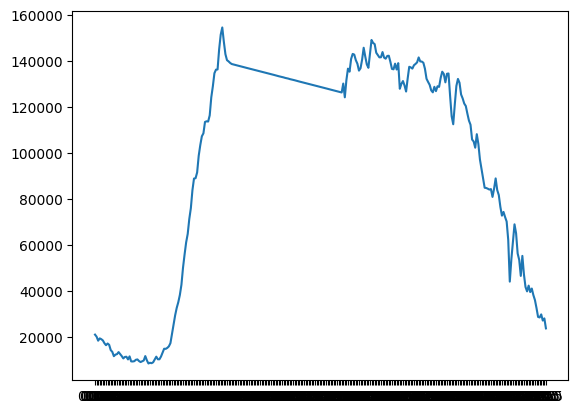

In [283]:
plt.plot(I_405_total_flow_test)

In [246]:
def plot_station_flow(interpolated_df, uninterpolated_df, num_intervals):
     if num_intervals not in [3, 6, 9, 12]:
          raise ValueError("'num_intervals' must be either 3, 6, 9, or 12.")

     # TODO: only slice the first row

     fig, ax = plt.subplots(figsize=(20, 6))

     # plot interpolated flow
     time_of_day = interpolated_df.columns[1:-3]
     interpolated_flow = interpolated_df.iloc[0, 1:-3]
     ax.plot(time_of_day, interpolated_flow)

     # plot uninterpolated flow
     uninterpolated_flow = uninterpolated_df.iloc[0, 1:-3]
     missing_flow = uninterpolated_flow[pd.isna(uninterpolated_flow)]
     missing_flow_x = missing_flow.index
     missing_flow_y = [interpolated_flow[time] for time in missing_flow_x]
     ax.plot(missing_flow_x, missing_flow_y, 'ro', label='Interpolated Flow')

     # only show every 15 minutes
     xtick_position = range(0, len(time_of_day), num_intervals)
     xtick_labels = time_of_day[::num_intervals]

     # set ax xticks
     ax.set_xticks(xtick_position)
     ax.set_xticklabels(xtick_labels, rotation=90)

     # set x-axis labels
     ax.set_xlabel('Time')

     # set y-axis labels
     ax.set_ylabel('Total Flow')

     # add a legend
     ax.legend()

     # show the plot
     plt.show()



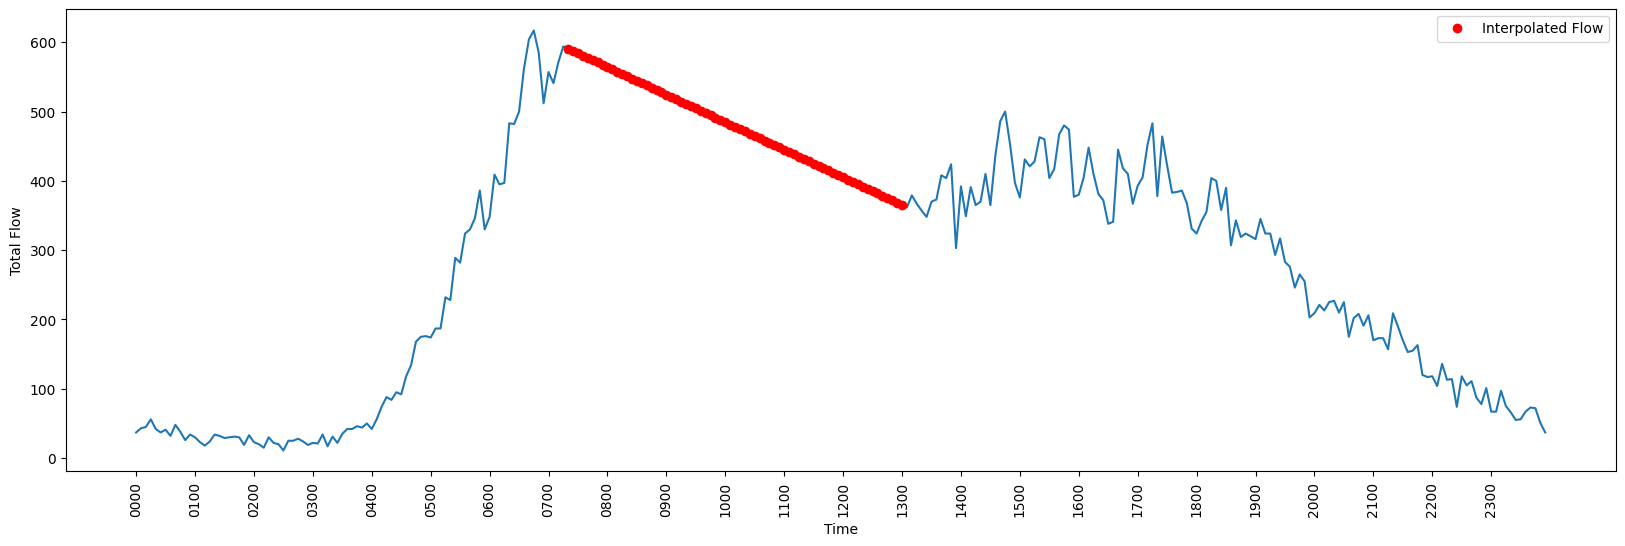

In [247]:
plot_station_flow(df_405N_ML_interpolated, df_405N_ML_merged, 12)

In [276]:
df_a = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5]})
df_c = pd.DataFrame({'PM': [0.03, 0.26, 0.35, 0.4, 0.49, 0.65], 'traffic_flow': [100, 200, 300, 400, np.nan, 600]})

# Create a boolean column indicating if the value was interpolated
df_c['interpolated'] = df_c['traffic_flow'].isna()

# Interpolate missing traffic_flow values in df_c
df_c['traffic_flow'] = df_c['traffic_flow'].interpolate()

# Create interval bins
bins = df_a['PM'].tolist() + [np.inf]

# Assign each PM in df_c to an interval in df_a
df_c['PM_range'] = pd.cut(df_c['PM'], bins=bins)

# Group by PM_range and calculate mean traffic_flow and maximum interpolated
traffic_flow_mean = df_c.groupby('PM_range').agg({'traffic_flow': 'mean', 'interpolated': 'max'}).reset_index()

traffic_flow_mean['PM'] = traffic_flow_mean['PM_range'].apply(lambda x: x.left)

# Merge the average traffic_flow and interpolated to df_a
df_final = pd.merge(df_a, traffic_flow_mean, on='PM', how='left')

# Clean up the final dataframe
df_final = df_final.drop(columns='PM_range')
df_final


,PM,traffic_flow,interpolated
0,0.0,100.0,0.0
1,0.1,NaN,NaN
2,0.2,200.0,0.0
3,0.3,350.0,0.0
4,0.4,500.0,1.0
5,0.5,600.0,0.0


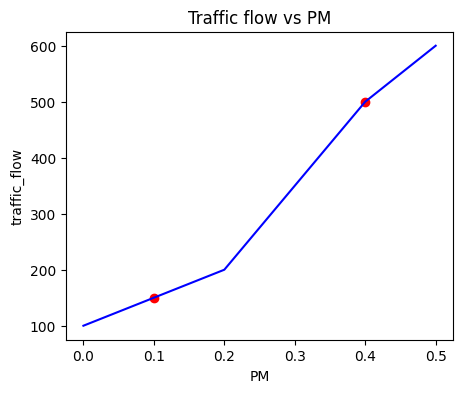

In [282]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 4))
# Plot all points with a line
plt.plot(df_d['PM'], df_d['traffic_flow'], color='blue')

# Overplot the interpolated points with red color
plt.scatter(df_d[df_d['interpolated']]['PM'],
            df_d[df_d['interpolated']]['traffic_flow'],
            color='red')

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

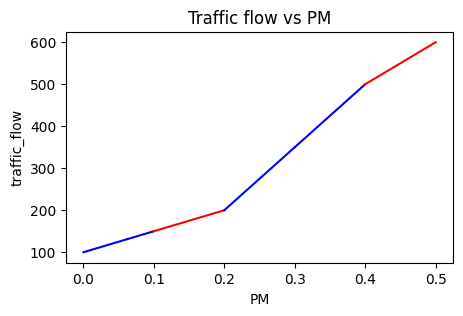

In [285]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 3))

# Loop over each segment
for i in range(len(df_d['PM']) - 1):
    x = df_d['PM'].iloc[i:i+2]
    y = df_d['traffic_flow'].iloc[i:i+2]

    # If the current point is interpolated, the line to the next point is red, else blue
    color = 'red' if df_d['interpolated'].iloc[i] else 'blue'
    plt.plot(x, y, color=color)

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()